# 가우시안 혼합

가우시안 혼합 모델(Gaussian Mixture Model, GMM)은 여러 개의 혼합된 가우시안 분포에서 샘플이 생성되었다고 가정하는 확률 모델을 의미한다. 

현실에 존재하는 복잡한 형태의 확률 분포를 k개의 가우시안 분포를 혼합해 표현하는 것이 GMM의 기본 아이디어이다.(각 가우시안 분포는 하나의 클러스터를 의미, 즉 k개의 클러스터)

GMM에서 $x$가 발생할 확률은 다음과 같이 여러 가우시안 분포 밀도 함수의 합으로 표현한다.

$$p(x) = \sum^K_{k=1} \pi_k N(x | \mu_k, \textstyle\sum_k)$$

여기서, $\pi_k$는 $k$번째 가우시안 분포가 선택될 확률을 나타내며, 다음의 조건을 만족한다.

$$0 \le \pi_k \le 1$$
$$\sum^K_{k=1}\pi_k = 1$$

**따라서, GMM을 학습시킨다는 것은 주어진 데이터 $X={x_1, x_2, \dots, x_N}$에 대한 $\pi_k$, $\mu_k$, $\sum_k$를 추정하는 것과 같다.**

GMM을 이용해 데이터가 어떠한 클러스터(가우시안 분포)에서 생성되었는지를 찾는 것은 다음과 같다.

먼저, responsibility $\gamma(z_{nk})$를 다음과 같이 정의한다.

$$\gamma(z_{nk}) = p(z_{nk}=1 | X_n)$$

위 식에서, $z_{nk} \in \{0, 1\}$는 $x_n$이 주어졌을 때, GMM의 k번째 가우시안 분포가 선택되면 1, 아니면 0을 갖는 값이므로, $z_{nk}$가 1이라는 것은 $x_n$이 k번째 가우시안 분포에서 생성되었다는 것을 의미한다.

학습을 통해 GMM의 모든 파라미터 $\pi_k$, $\mu_k$, $\sum_k$가 결정된다면, $\gamma(z_{nk})$를 계산할 수 있다.(자세한 과정은 생략)

**따라서, GMM을 이용해 클러스터를 찾는 것(GMM classification)은 다음과 같이 $x_n$이 주어졌을 때, k개의 $\gamma(z_{nk})$를 계산해 가장 값이 높은 가우시안 분포를 선택하는 것이다.**

<img src="./images/gmm_classification.png" alt="gmm_classification">

다음은 사이킷런의 `GaussianMixture`클래스를 사용해 GMM을 학습시키는 예이다.

In [1]:
# 데이터셋 생성
import numpy as np
from sklearn.datasets import make_blobs

X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [2]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

이제 추정한 파라미터 $\pi_k$, $\mu_k$, $\sum_k$를 확인해보자.

In [3]:
# pi
print(gm.weights_)
# mu
print(gm.means_)
# sum
print(gm.covariances_)

[0.3902064  0.20970929 0.40008431]
[[ 0.0512132   0.07512971]
 [ 3.39854326  1.05926051]
 [-1.4076241   1.42704927]]
[[[ 0.68780591  0.79597839]
  [ 0.79597839  1.21232694]]

 [[ 1.14901133 -0.03241901]
  [-0.03241901  0.95484861]]

 [[ 0.63480459  0.72971575]
  [ 0.72971575  1.16110086]]]


### 기댓값-최대화(Expectation-Maximization, EM) 알고리즘
일반적으로 GMM은 이러한 추정 과정은 주어진 데이터 $X={x_1, x_2, \dots, x_N}$에 대해 기댓값-최대화(Expectation-Maximization, EM)알고리즘을 적용해 파라미터 $\pi_k$, $\mu_k$, $\sum_k$를 추정한다.

이 알고리즘은 클러스터 파라미터를 랜덤하게 초기화하고, 아래의 두 단계를 수렴할 때까지 반복한다.
#### 1. Expectation step (E-step)
샘플을 클러스터에 할당한다. 즉, 모든 데이터와 가우시안 분포에 대해 $\gamma(z_{nk})$를 계산한다.

#### 2. Maximization step (M-step)
클러스터를 업데이트한다. 즉, 가우시안 분포에 대한 $\pi_k$, $\mu_k$, $\sum_k$를 추정한다.

<img src="./images/em_algorithm.png" alt="em_algorithm">

알고리즘이 수렴했는지 여부와 반복 횟수는 다음의 코드를 통해 확인할 수 있다.

In [4]:
print(gm.converged_)
print(gm.n_iter_)

True
4


이제 학습시킨 GMM을 통해 새로운 샘플을 가장 비슷한 클러스터에 할당(hard clustering)하거나 특정 클러스터에 속할 확률(soft clustering)을 예측할 수 있다.

In [5]:
# hard clustering
print(gm.predict(X))

[0 0 2 ... 1 1 1]


In [6]:
# soft clustering
print(gm.predict_proba(X))

[[9.76688618e-01 2.33107018e-02 6.80230786e-07]
 [9.82774531e-01 1.65481663e-02 6.77302883e-04]
 [7.42085667e-05 2.04358925e-06 9.99923748e-01]
 ...
 [4.21582331e-07 9.99999578e-01 2.17682412e-26]
 [4.93027253e-16 1.00000000e+00 1.50345348e-41]
 [2.19825399e-15 1.00000000e+00 8.24833927e-41]]


GMM은 생성 모델(generative model)이므로, 이 모델에서 새로운 샘플을 만들 수 있다.

In [7]:
X_new, y_new = gm.sample(6)

print(X_new)
print(y_new)

[[-0.56938698 -1.8422361 ]
 [ 0.39902497 -0.02967058]
 [ 1.38664127  1.01947538]
 [ 0.16358063 -0.76694205]
 [ 3.13867587  1.765726  ]
 [ 3.48046945  2.12775841]]
[0 0 0 0 1 1]


또한, 샘플이 주어지면 그 위치의 PDF(probability density function)의 로그값을 예측해 모델의 밀도를 측정할 수 있다. 점수가 높을수록 밀도가 높다.

In [8]:
print(gm.score_samples(X))

[-2.60753797 -3.57117632 -3.32962239 ... -3.51337454 -4.39800533
 -3.80760349]


이 score의 지수값을 계산하면, 샘플 위치의 PDF를 얻을 수 있다. 따라서, 이를 적분하면, 해당 지역안에 속할 확률을 예측할 수 있다.

다음은 학습한 GMM의 평균, 결정 경계, 밀도 등고선을 그리는 코드이다.

In [9]:
from matplotlib.colors import LogNorm

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

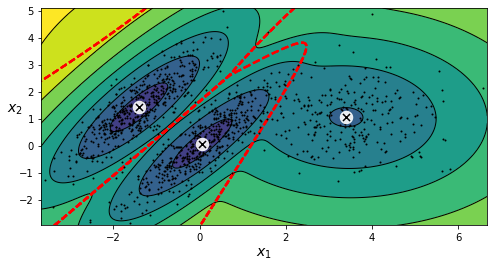

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)

plt.show()

특성이나 클러스터가 많거나 샘플이 적을 때는 EM이 최적의 솔루션으로 수렴하기 어렵다. 이러한 경우에서는 알고리즘이 학습할 파라미터의 개수를 제한해야 한다.

이를 위한 방법으로는, 클러스터의 모양과 방향의 범위를 제한하는 것이다. 사이킷런에서는 `covariance_type`에 다음의 값 설정을 통해 이를 수행할 수 있다.
- `"spherical"` : 모든 클러스터가 원형
- `"diag"` : 클러스터는 크기에 상관없이 어떤 타원형도 가능
- `"tied"` : 모든 클러스터가 동일한 타원 모양, 크기, 방향을 가짐

다음은 이들을 사용해 EM 알고리즘이 찾은 솔루션을 그리는 코드이다.

In [11]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [12]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)

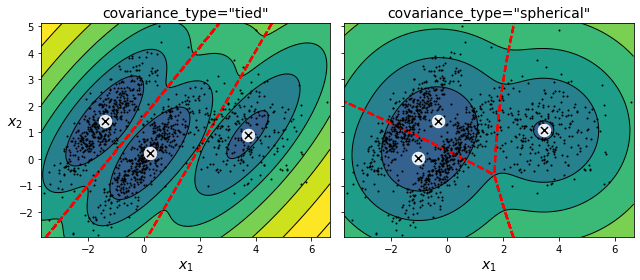

In [13]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)
plt.tight_layout()
plt.show()

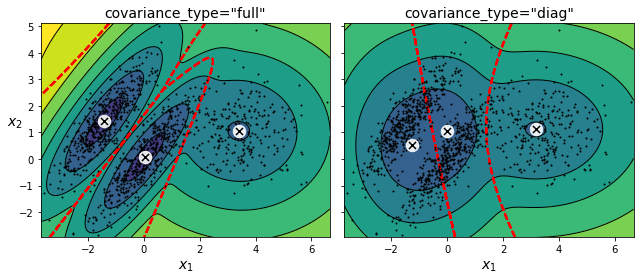

In [14]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

## 가우시안 혼합을 사용한 이상치 탐지

**이상치 탐지(anomaly detection 또는 outlier detection)**는 보통과 많은 다른 샘플을 감지하는 작업이다. 이를 이상치(outlier)라고 부르고, 보통 샘플을 정상치(inlier)라고 한다.

GMM을 이용하면, 밀도가 낮은 지역에 있는 샘플을 이상치로 볼 수 있다. 이를 위해서는 밀도의 임곗값을 지정해야 한다.

임계값에 따른 결과는 다음과 같다.
- 낮은 임계값 : 많은 false positives가 생김 (정상적인 제품도 결함이 있다고 간주됨)
- 높은 임계값 : 많은 false negatives가 생김 (결함이 있는 제품도 정상이라고 간주됨)

다음은 4%를 밀도 임곗값으로 사용해 이상치를 구분하는 예이다.

In [15]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

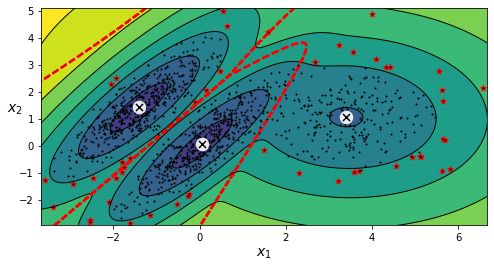

In [16]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

plt.show()

위 그림에서, 별모양으로 표시된 것들이 이상치이다.

### 특이치 탐지
**특이치 탐지(novelty detection)**는 이상치 탐지와 반대로, 이상치로 오염되지 않은 데이터에서 훈련하는 알고리즘이다.

## 클러스터 개수 선택하기

GMM에서는 클러스터가 타원형이거나 크기가 다르므로, k-평균에서처럼 inertia나 silhouette score과 같은 지표를 사용할 수 없다.

대신 다음의 식으로 정의되는 BIC(Bayesian information criterion)나 AIC(Akaike information criterion)와 같은 이론적 정보 기준(theoretical information criterion)을 최소화 하는 모델을 찾는다.

$$BIC = log(m)p-2log(\hat{L})$$
$$AIC = 2p-2log(\hat{L})$$

위 식에서, 각 항의 의미는 다음과 같다.
- $m$ : 샘플의 개수
- $p$ : 모델이 학습할 파라미터 개수
- $\hat{L}$ : 모델의 가능도 함수(likelihood function)의 최댓값

`bic()`와 `aic()`를 사용하면, BIC와 AIC를 계산할 수 있다.

In [17]:
print(gm.bic(X))
print(gm.aic(X))

8189.756836104972
8102.531555989934


다음과 같이 여러가지 클러스터 개수 k에 대한 BIC, AIC 그래프를 그려보고, 최선의 k값을 찾을 수 있다.

In [18]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [19]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

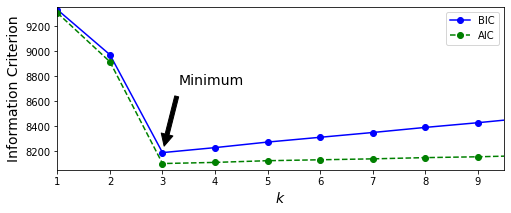

In [20]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

위 결과에서, k=3이 최선의 클러스터 수라는 것을 알 수 있다.

### 가능도 함수 (Likelihood Function)

통계학에서 확률(probability)와 가능도(likelihood)는 다른 의미를 가진다.

- **확률**은 파라미터 $\mathbf{\theta}$인 확률 모델이 주어지면($\mathbf{\theta}$를 알고 있을 때) 미래 출력 $\mathbf{x}$가 얼마나 그럴듯한지를 설명한다.
- **가능도**는 출력 $\mathbf{x}$를 알고 있을 때 특정 파라미터 $\mathbf{\theta}$가 얼마나 그럴듯한지를 설명한다.

예를 들어, 각각 -4와 +1이 중심인 두개의 가우시안 분포를 가진 혼합 모델이 있다고 하자. 이 모델은 두 분포의 표준편차를 제어하기 위한 파라미터 $\theta$를 가진다.

다음의 그림에서, 왼쪽 위 그래프는 $x$와 $\theta$의 함수로 전체 모델 $f(x;\theta)$를 나타낸다.

<img src="./images/likelihood.png" alt="likelihood">

모델의 파라미터 $\theta$를 1.3으로 설정했다면, 왼쪽 아래와 같은 PDF $f(x;\theta=1.3)$을 얻는다. 여기서, x가 -2와 2사이에 있을 확률은 해당 구간을 적분하면 된다.(회색 면적)

오른쪽 위 그래프는 $\theta$를 모르는 대신 샘플 x=2.5를 관측한 경우에 나타난 가능도 함수 $L(\theta | x=2.5) = f(x=2.5;\theta)$이다. 오른쪽 아래는 이에 로그를 취한 로그 가능도 함수이다.

**정리하자면, PDF는 $x$의 함수이고, 가능도 함수는 $\theta$의 함수이다. 중요한 것은 가능도 함수는 모든 $\theta$에 대해 적분하여도, 항상 1이되지 않으므로 확률 분포가 아니라는 것이다.**

데이터셋 $X$가 주어졌을 때, 모델 파라미터의 가장 그럴듯한 값을 찾기 위해서는, $X$에 대한 가능도 함수를 최대화 하는 값을 찾아야 한다.

로그의 곱셈은 덧셈으로 바꿀 수 있으므로, 함수의 로그를 최대화 하는 것이 더욱 쉽다. 따라서 $log L(\theta | x)$를 최대화 한다.

이를 통해 가능도 함수를 최대화하는 $\theta$값인 $\hat{\theta}$를 추정하고 나면, AIC와 BIC를 계산하기 위해 필요한 $\hat{L}=L(\hat{\theta}, \mathbf{X})$를 계산할 수 있다.

## 베이즈 가우시안 혼합 모델

베이즈 가우시안 혼합 모델은 최적의 클러스터 개수를 수동으로 찾는 것 대신에 불필요한 클러스터의 가중치를 0으로 만드는 방법이다.

다음은 사이킷런의 `BayesianGaussianMixture`를 사용해 베이즈 가우시안 혼합 모델을 사용하는 예이다.

In [21]:
from sklearn.mixture import BayesianGaussianMixture

# n_components를 최적의 클러스터 수보다 크고 믿을만한 값으로 설정
bgm = BayesianGaussianMixture(n_components=10, n_init=10)
bgm.fit(X)
print(np.round(bgm.weights_, 2))

[0.   0.21 0.39 0.4  0.   0.   0.   0.   0.   0.  ]


위 결과에서, 3개의 클러스터 외에 나머지는 가중치가 0이므로, 3개의 클러스터가 필요하다는 알 수 있다.

(베이즈 가우시안 혼합 모델과 관련된 깊은 이론은 생략.)